### Inspect the batch times of the Gridion barcoded experiment and the promethion barcoded experiment

Uses the old format of readfish logs - <>R/<>S

Runs were simulated using Icarust 0.0.7, commit cf27f12071f7c9b515883d5e3bf645aad4609831 using the `config_dnar10_5Khz_human_barcoded.toml`, a copy of which has been included in this repository.
They were run for two hours a piece using the command:
```bash
cargo run -r -- -s Profile_tomls/config_dnar10_5khz_human_barcoded.toml -c config_grid.ini -v -p 
```

Where the number of channels and the break_read_chunks was changed to 512 and 0.8 for prom and 3000 and 1.0 for prom. 

On a Promethion P48 Beta tower. The basecalling server was dorado using the following comand:

```bash
sudo ./bin/dorado_basecall_server --log_path /var/log/dorado -d /data/projects/rory_says_hi/ont-dorado-server/data/ --config dna_r10.4.1_e8.2_400bps_5khz_fast_prom.cfg --ipc_threads 16 --port /tmp/.guppy/5556 --dorado_download_path /opt/ont/dorado-models --device cuda:all --num_alignment_threads 24
```

The profiling files were agthered using a special fork of readfish 2024.2.0, commit cd20ff16c5f3a5f54124515fe58aabde3dc8df3a
https://github.com/LooseLab/readfish/tree/profiling

The readfish logs for the experiments in the paper comparing NA12878 vs. 22Rv1 and NB4 are also included and they are analysed at the start of this notebook.

In [147]:
import argparse
import lzma
import re
import sys
from itertools import pairwise
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter, ScalarFormatter, EngFormatter

In [148]:
# Supress the Setting with copy warning in the facetted function
pd.options.mode.chained_assignment = None
mpl.rcParams.update(
    {
        "figure.dpi": 300,
        "figure.facecolor": "w",
        "axes.grid": True,
        "savefig.facecolor": "w",
    }
)

### Analyse the original logs.

In [3]:
def reader(fn):
    pat = re.compile(r"(.*?) [\w\.]+ (\d+)R\/(\d+.\d+)s")

    def _reader(fh):
        for line in fh:
            if m := pat.findall(line):
                yield m[0]

    handler = lzma.open if fn.endswith("xz") else open
    with handler(fn, "rt") as fh:
        df = pd.DataFrame(_reader(fh), columns=["Time", "Reads", "Duration (s)"])
    df["Time"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S,%f")
    df[["Reads", "Duration (s)"]] = df[["Reads", "Duration (s)"]].astype("float")
    df["Per read (s)"] = df["Duration (s)"] / df["Reads"]
    return df


def plot(data, filename, threshold, name=None, y="Duration (s)", ax=None):
    data = data.sort_values("Time", ascending=True)
    colour = np.where(data["Duration (s)"].gt(threshold), "r", "b")
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 6))
    sns.scatterplot(
        data=data,
        x="Time",
        y=y,
        c=colour,
        alpha=0.25,
        linewidths=0,
        edgecolor=None,
        s=data["Reads"].pow(1 / 2),
        ax=ax,
    )
    sns.rugplot(data=data, x="Time", y=y, lw=1, alpha=0.005)
    gradation = 0.1
    # plt.yticks(np.arange(0, np.ceil(data["Per read"].max()) + gradation, gradation))
    if name is not None:
        fig.suptitle(name)
    fig.tight_layout()
    fig.savefig(filename)
    return ax

In [4]:
df_prom = pd.concat([reader(f) for f in ["ru_prom_mappyrs.log.xz"]], ignore_index=True)

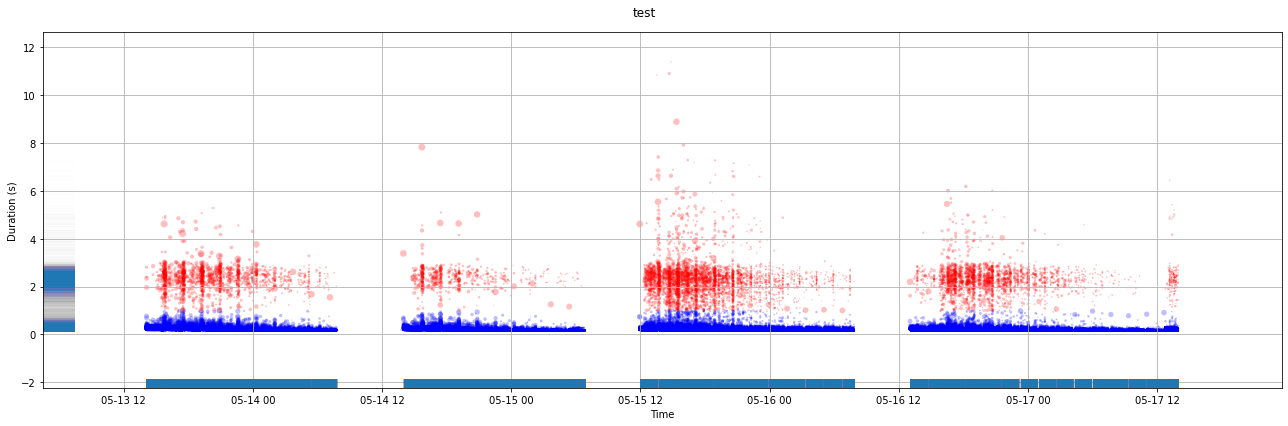

In [5]:
fig = plot(df_prom, "test.pdf", 1, "test")

(0.0001, 1)

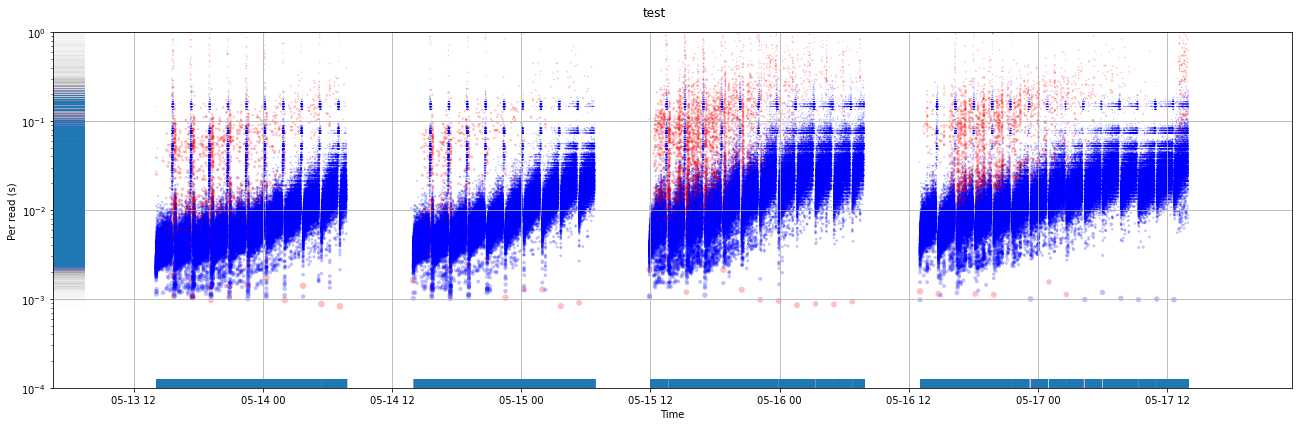

In [7]:
ax = plot(df_prom, "test.pdf", 1, "test", y="Per read (s)")
plt.yscale("log")
ax.set_ylim((0.0001, 1))

### Profiling, using the sexy new branch of readfish
Ran against Icarust which was simulating either HG38 simple or HG38 simple chr1.


In [151]:
dfs = []
for f in Path().glob("profile_log*.tsv.xz"):
    print(f)
    df = pd.read_csv(
        f,
        sep="\t",
        header=None,
        names="Loop\tStage\tCPU Usage (%)\tMemory Usage (MB)\tTime (s)\tCum. Time (s)\tNum. Chunks\tYield\tBase\tAl".split(
            "\t"
        ),
    )
    sequencer, aligner = re.findall(
        r"(prom|gridion)_(mappy_rs|mappy|built_in)", f.stem
    )[0]
    df["Sequencer"] = sequencer
    df["Aligner"] = aligner
    df["Sequencer/Aligner"] = f"{sequencer}/{aligner}"
    # df["aligner"] = aligner
    dfs.append(df)
df_sim = pd.concat(dfs)
df_sim[["Timestamp", "Loop"]] = df_sim["Loop"].str.split(",", expand=True)

profile_log_prom_mappy_rs.tsv.xz
profile_log_gridion_mappy.tsv.xz
profile_log_gridion_built_in.tsv.xz
profile_log_gridion_mappy_rs.tsv.xz
profile_log_prom_built_in.tsv.xz
profile_log_prom_mappy.tsv.xz


In [137]:
numerical_columns = [
    "Loop",
    "Yield",
    "Time (s)",
    "Cum. Time (s)",
    "Num. Chunks",
    "Yield",
    "Base",
    "Al",
]
for numerical_column in numerical_columns:
    df_sim[numerical_column] = pd.to_numeric(df_sim[numerical_column], errors="coerce")
df_sim["Timestamp"] = pd.to_datetime(df_sim["Timestamp"])

Get only the total loop time, which starts when we query for a new batch of read chunks and finishes after we have basecalled, aligned and sent decisions for all chunks in batch

In [138]:
df_all = df_sim[df_sim["Stage"] == "Total loop"].sort_values("Loop")
# Set the alignment time to match the basecalling time for built in dorado alignments, as there is no way of seperating these, they are essentially the same wghen dorado does the alignments
df_all["Al"] = np.where(
    df_all["Sequencer/Aligner"].str.contains("built"), df_all["Base"], df_all["Al"]
)

The number of time run for

In [140]:
(
    df_all.groupby("Sequencer/Aligner")["Timestamp"].max()
    - df_all.groupby("Sequencer/Aligner")["Timestamp"].min()
)

Sequencer/Aligner
gridion/built_in   0 days 01:57:31
gridion/mappy      0 days 01:55:32
gridion/mappy_rs   0 days 01:55:55
prom/built_in      0 days 04:17:05
prom/mappy         0 days 00:01:38
prom/mappy_rs      0 days 01:43:13
Name: Timestamp, dtype: timedelta64[ns]

#### Plot bivariate of alignment time vs. basecalling time, all on one plot, splitting them out by hue and kde density esitmates in the margins

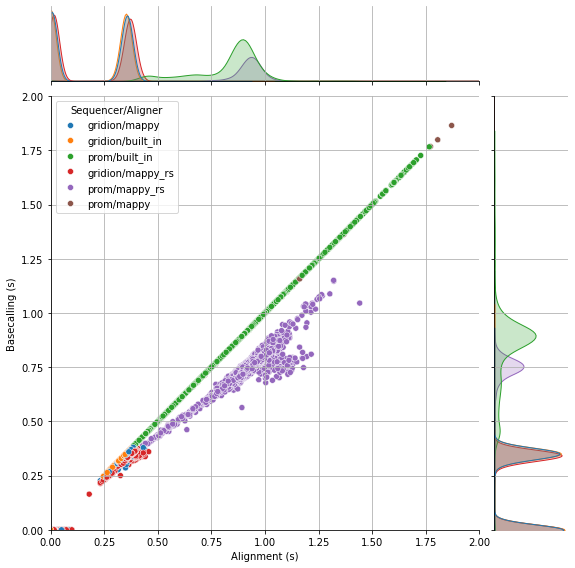

In [44]:
g = sns.jointplot(
    data=df_all,
    x="Al",
    y="Base",
    kind="scatter",
    height=8,
    hue="Sequencer/Aligner",
)

# Set the limits
g.ax_joint.set_xlim(0, 2)
g.ax_joint.set_ylim(0, 2)
g.set_axis_labels(
    xlabel="Alignment (s)",
    ylabel="Basecalling (s)",
)
g.savefig("test.pdf")

In [141]:
# Normalise the number of bases in a batch by the number of reads in that batch
df_all["Mean Read Len."] = df_all["Yield"] / df_all["Num. Chunks"]
# For batches with no chunks in
df_all["Mean Read Len."] = df_all["Mean Read Len."].fillna(0.0)

#### Plot bivariate of alignment time vs. basecalling time, all on one plot, splitting them out by hue and kde density esitmates in the margins
But this time do it manuall, so we can weight the size of the points on the plot by the number of bases in a batch, and also stack the kde density

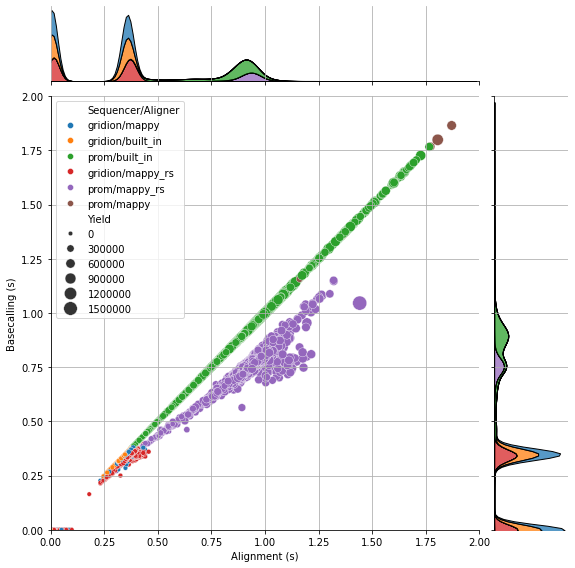

In [45]:
g = sns.JointGrid(
    data=df_all,
    x="Al",
    y="Base",
    hue="Sequencer/Aligner",
    height=8,
)
# g.plot_joint(sns.scatterplot, sizes=(20,200), alpha=0.5)
data = df_all[(df_all["Al"] <= 2.0) & (df_all["Base"] <= 2.0)]
sns.scatterplot(
    ax=g.ax_joint,
    size="Yield",
    hue="Sequencer/Aligner",
    data=data,
    x="Al",
    y="Base",
    sizes=(20, 200),
)
sns.kdeplot(
    ax=g.ax_marg_x,
    data=data,
    x="Al",
    multiple="stack",
    hue="Sequencer/Aligner",
    legend=False,
    gridsize=200,
)
sns.kdeplot(
    ax=g.ax_marg_y,
    data=data,
    y="Base",
    multiple="stack",
    hue="Sequencer/Aligner",
    legend=False,
    gridsize=200,
)
g.ax_joint.set_xlim(0, 2)
g.ax_joint.set_ylim(0, 2)
g.set_axis_labels(
    xlabel="Alignment (s)",
    ylabel="Basecalling (s)",
)
g.savefig("test_manual_weights.pdf", dpi=300, bbox_inches="tight")

#### Same as above Jointplot, but weighted by the mean read length of the batch

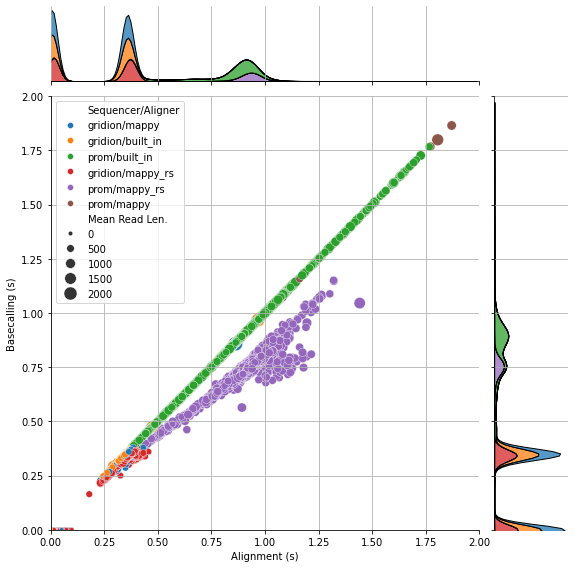

In [142]:
g = sns.JointGrid(
    data=df_all,
    x="Al",
    y="Base",
    hue="Sequencer/Aligner",
    height=8,
)
# g.plot_joint(sns.scatterplot, sizes=(20,200), alpha=0.5)
data = df_all[(df_all["Al"] <= 2.0) & (df_all["Base"] <= 2.0)]
sns.scatterplot(
    ax=g.ax_joint,
    size="Mean Read Len.",
    hue="Sequencer/Aligner",
    data=data,
    x="Al",
    y="Base",
    sizes=(20, 200),
)
sns.kdeplot(
    ax=g.ax_marg_x,
    data=data,
    x="Al",
    multiple="stack",
    hue="Sequencer/Aligner",
    legend=False,
    gridsize=200,
)
sns.kdeplot(
    ax=g.ax_marg_y,
    data=data,
    y="Base",
    multiple="stack",
    hue="Sequencer/Aligner",
    legend=False,
    gridsize=200,
)
g.ax_joint.set_xlim(0, 2)
g.ax_joint.set_ylim(0, 2)
g.set_axis_labels(
    xlabel="Alignment (s)",
    ylabel="Basecalling (s)",
)
g.savefig("test_manual_weights.pdf", dpi=300, bbox_inches="tight")

In [143]:
# Function to create a size legend with absolute sizes as determined by the plot
def create_size_legend(ax, global_min, global_max, scale=100):
    handles = []
    labels = [
        100_000,
        300_000,
        500_000,
        1_000_000,
        2_500_000,
        5_000_000,
        10_000_000,
    ]  # Absolute sizes you want to display
    for size in labels:
        normalized_size = normalize_sizes(
            np.array([size]), global_min, global_max, scale
        )
        handles.append(
            plt.scatter(
                [], [], s=normalized_size, alpha=0.5, color="gray", edgecolors="w"
            )
        )
    legend = ax.legend(
        handles,
        labels,
        title="Size (absolute)",
        scatterpoints=1,
        frameon=True,
        labelspacing=1,
    )
    ax.add_artist(legend)

In [144]:
# Function to determine colors based on size limits

def get_colors(sizes, limits=None):
    limits = [-1, 250_000, 500_000, 750_000, 1_000_000] if limits is None else limits
    conditions = [(sizes > a) & (sizes <= b) for a, b in pairwise(limits)]
    conditions.append((sizes > limits[-1]))
    choices = ["green", "orange", "red", "blue", "purple", "yellow", "teal"]
    return np.select(conditions, choices[: len(conditions)], default="gray")

In [145]:
# Function to create a size legend with absolute sizes
def create_color_legend(fig, labels=None, title="Num. bases"):
    colors = ["green", "orange", "red", "blue", "purple", "yellow", "teal"]
    labels = (
        [
            "< 250,000",
            "250,001 - 500,000",
            "500,001 - 750,000",
            "750,001 - 1,000,000",
            "> 1,000,000",
        ]
        if labels is None
        else [f"{a+1} - {b}" for a, b in pairwise(labels)] + [f"> {labels[-1]}"]
    )
    handles = [
        plt.Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=color, markersize=10
        )
        for color in colors[: len(labels)]
    ]
    legend = fig.legend(
        handles,
        labels,
        title=title,
        scatterpoints=1,
        frameon=True,
        labelspacing=1,
        bbox_to_anchor=(0.98, 0.65),
        loc="center right",
    )
    return legend

In [146]:
df_all = df_all.sort_values(["Sequencer/Aligner"])

#### As it was hard to groupings where sequencers piled up points on the above plots, split them out into a faceted grid
Code for facet grid taken from https://github.com/mwaskom/seaborn/blob/09195d4c314d9477866ba4bd5cb650c3a7c01e41/seaborn/axisgrid.py#L1679

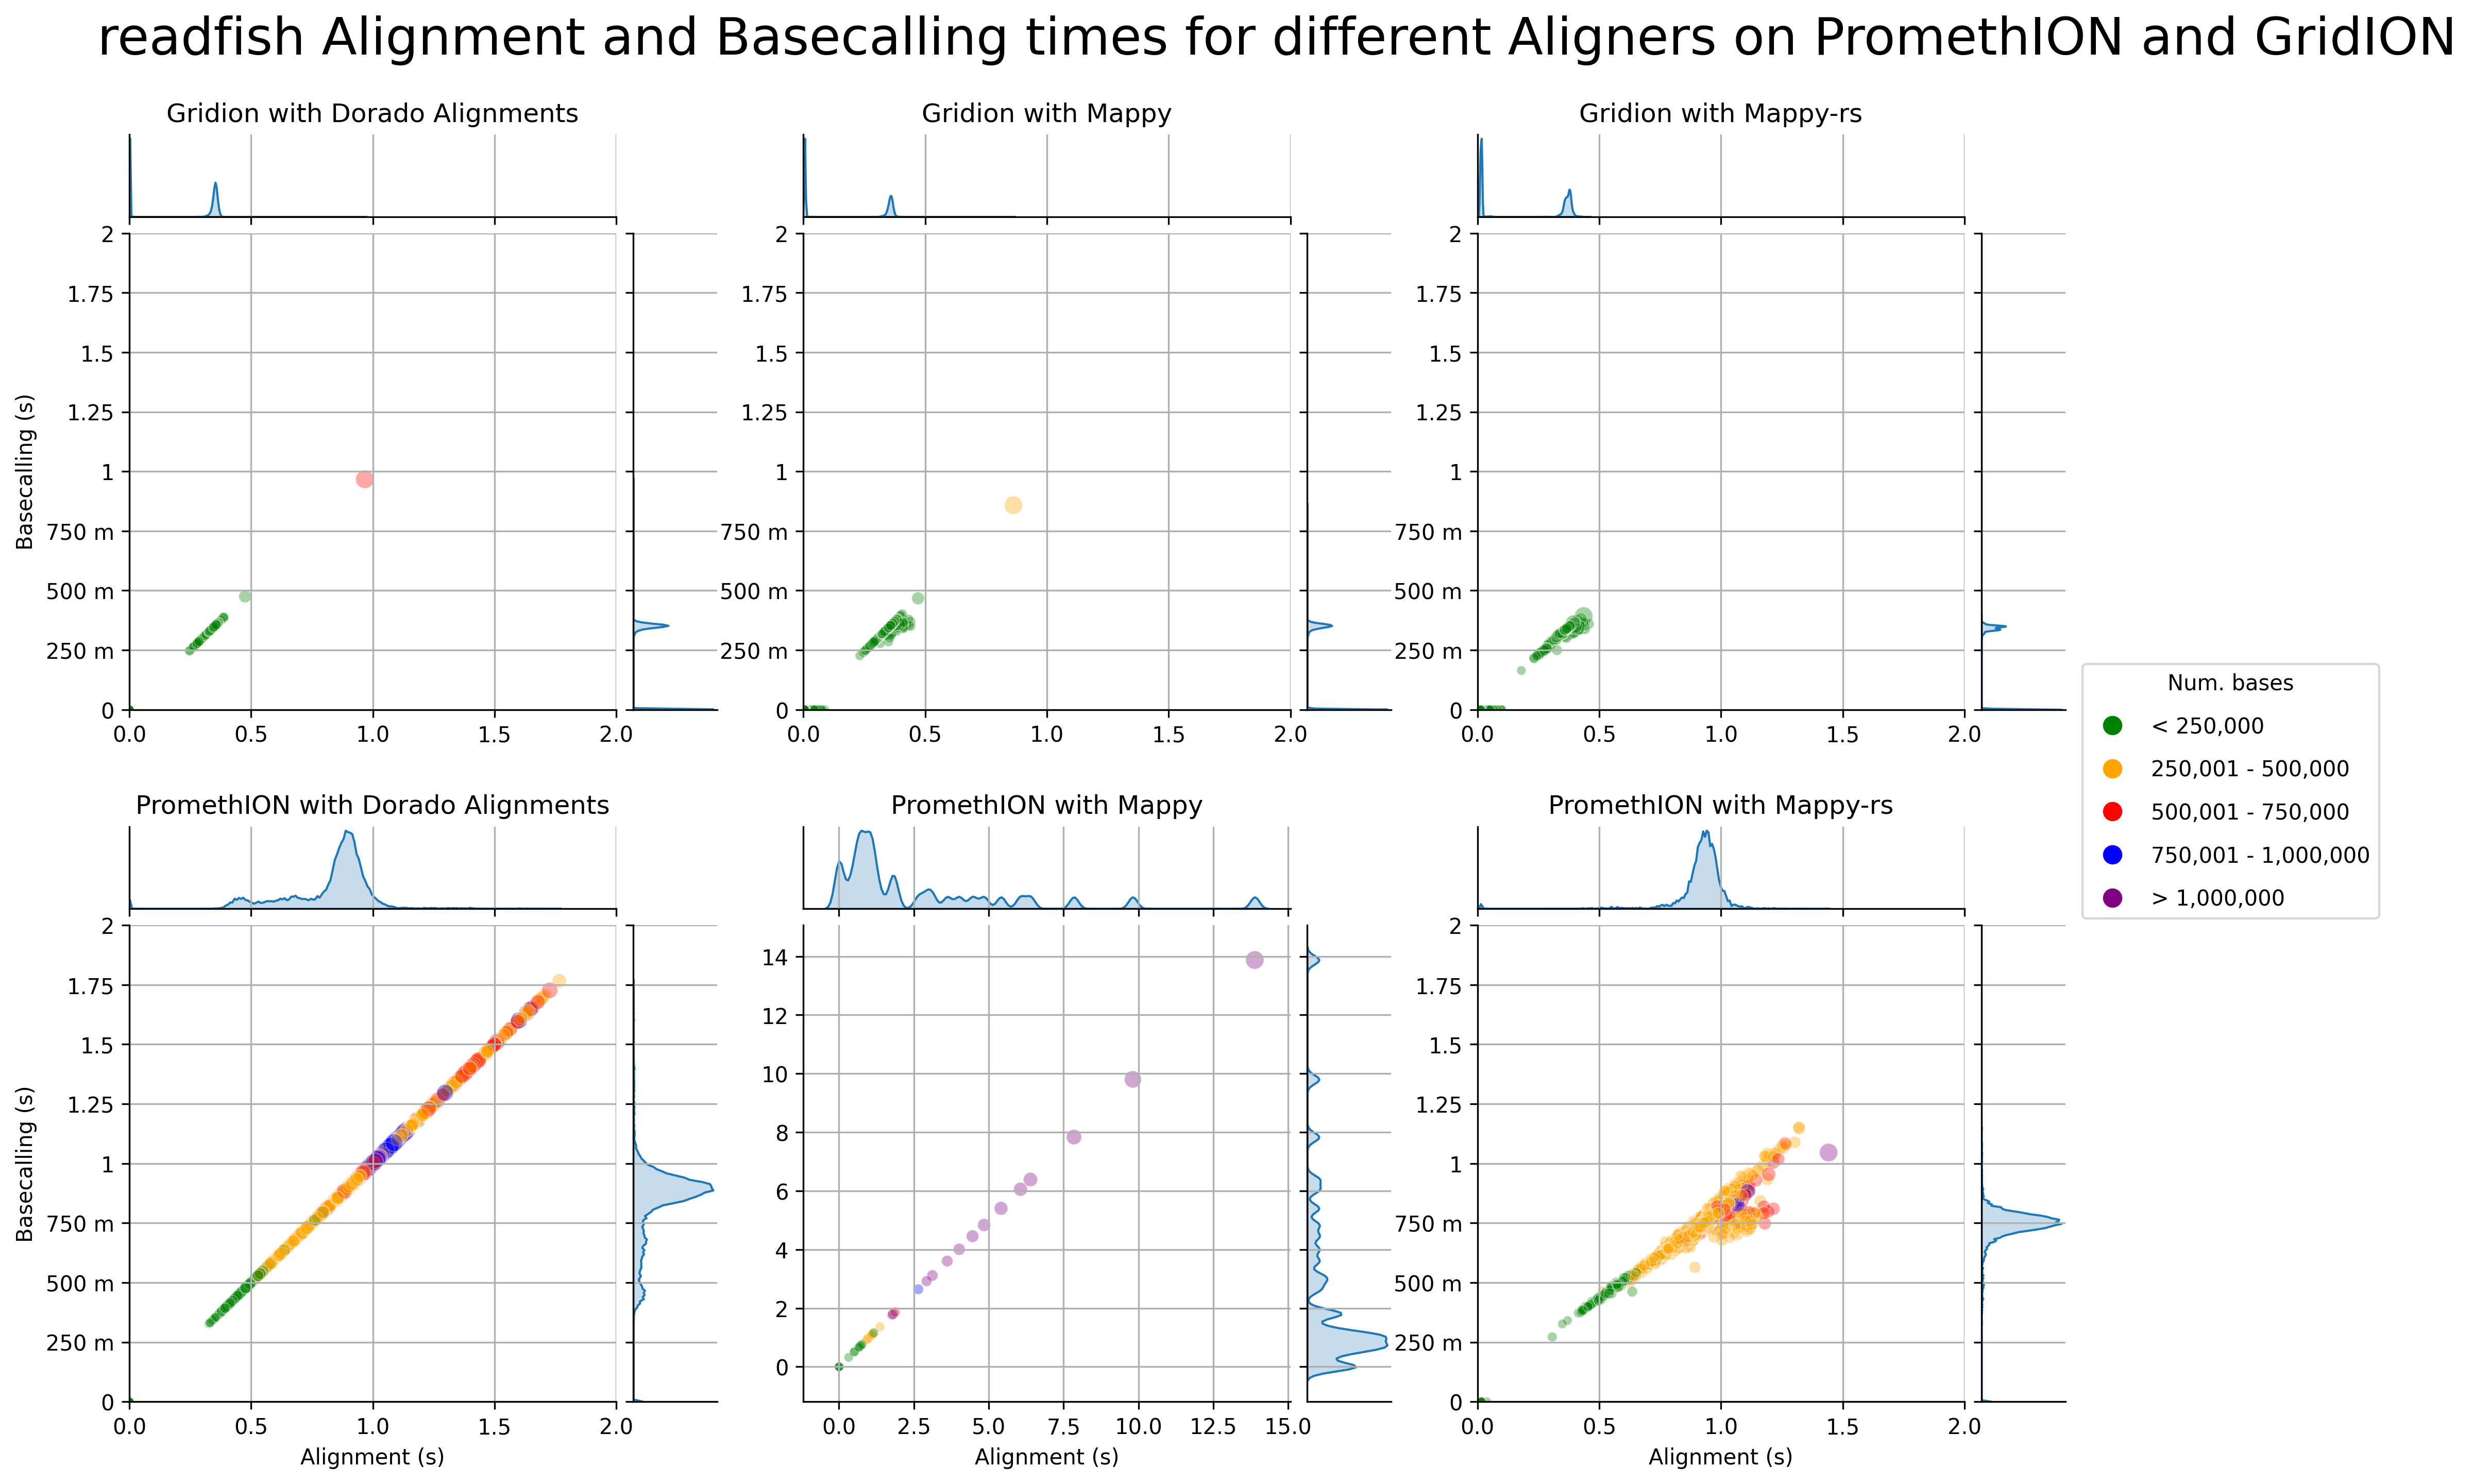

In [149]:
# Normalise the bases by size across all different aligner/sequencer combinations, otherwise each axis has it'w own max/min size and they aren't comparable ( this now is range [0-1])
df_all["Norm. bases"] = (
    (df_all["Yield"] - df_all["Yield"].min())
    / (df_all["Yield"].max() - df_all["Yield"].min())
    * 100
)
# nice name
lookup = {
    "gridion": "Gridion",
    "prom": "PromethION",
    "mappy": "Mappy",
    "mappy_rs": "Mappy-rs",
    "built_in": "Dorado Alignments",
}



def draw_facetted_joints(
    df: pd.DataFrame,
    x="Al",
    y="Base",
    s="Yield",
    row: str = "Sequencer",
    col: str = "Aligner",
    ratio: int = 5,
    out_file: str | Path = "test.pdf",
    legend_labels: list[str] = None,
    legend_title="Num. bases",
    legend_limits=None,
):
    cols = df_all[col].unique()
    rows = df_all[row].unique()
    ncols = len(cols)
    nrows = rows.shape[0]
    fig = plt.figure(figsize=(ratio * ncols, ratio * nrows))
    gs = plt.GridSpec((ratio * nrows) + nrows, (ratio * ncols) + ncols)
    for row_idx, row in enumerate(rows):
        for col_idx, col in enumerate(cols):
#             Pure magic worked out by grid height, sow we can insert the axis for the marginal axes inbetween the main plot axes
            sub_grid_row_height = ((row_idx + 1) + row_idx * ratio), (
                ratio * (row_idx + 1)
            ) + (row_idx + 1)
            sub_grid_col_height = (
                col_idx * ratio + col_idx,
                (col_idx + 1) * ratio + col_idx,
            )
            
            ax_joint = fig.add_subplot(
                gs[
                    sub_grid_row_height[0] : sub_grid_row_height[1],
                    sub_grid_col_height[0] : sub_grid_col_height[1],
                ]
            )
            ax_marg_x = fig.add_subplot(
                gs[
                    sub_grid_row_height[0] - 1,
                    sub_grid_col_height[0] : sub_grid_col_height[1],
                ],
                sharex=ax_joint,
            )

            ax_marg_y = fig.add_subplot(
                gs[
                    sub_grid_row_height[0] : sub_grid_row_height[1],
                    sub_grid_col_height[1],
                ],
                sharey=ax_joint,
            )
#             Make the plot look nice
            plt.setp(ax_marg_x.get_xticklabels(), visible=False)
            plt.setp(ax_marg_y.get_yticklabels(), visible=False)
            plt.setp(ax_marg_x.get_xticklabels(minor=True), visible=False)
            plt.setp(ax_marg_y.get_yticklabels(minor=True), visible=False)
            plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
            plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
            plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
            plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
            plt.setp(ax_marg_x.get_yticklabels(), visible=False)
            plt.setp(ax_marg_y.get_xticklabels(), visible=False)
            plt.setp(ax_marg_x.get_yticklabels(minor=True), visible=False)
            plt.setp(ax_marg_y.get_xticklabels(minor=True), visible=False)
            ax_marg_x.yaxis.grid(False)
            ax_marg_y.xaxis.grid(False)
            # Manually adjust the space between specific subplots, otherwise they're too smushed together
            dx, dy = 0.0, 0.0
#             Magic maths I had to work out so they space outwards from the center with outer ones going further than inner ones
            dx -= abs(ncols - col_idx + 1) * 0.03
            dy += abs(nrows - row_idx + 1) * 0.065
            for ax in [ax_joint, ax_marg_x, ax_marg_y]:
                pos = ax.get_position()
                new_pos = [
                    pos.x0 + dx,
                    pos.y0 + dy,
                    pos.width,
                    pos.height,
                ]  # Move ax4 up by 0.05
                ax.set_position(new_pos)
#             Subset the main dataframe
            df_view = df[(df["Sequencer"] == row) & (df["Aligner"] == col)]
            df_view["colour"] = get_colors(df_view[s], limits=legend_limits)

            sns.scatterplot(
                data=df_view,
                x="Al",
                c=df_view["colour"],
                y="Base",
                size=df_view[s],
                ax=ax_joint,
                legend=False,
                alpha=0.35,
            )

            ax_marg_x = sns.kdeplot(
                data=df_view,
                x="Al",
                ax=ax_marg_x,
                bw_adjust=0.1,
                fill=True,
                # palette="crest",
            )
            ax_marg_y = sns.kdeplot(
                data=df_view,
                y="Base",
                ax=ax_marg_y,
                bw_adjust=0.1,
                fill=True,
                # palette="crest",
            )
            
            if not (row, col) == ("prom", "mappy"):
                ax_joint.set_xlim(0, 2)
                ax_joint.set_ylim(0, 2)
            ax_marg_x.set_title(f"{lookup[row]} with {lookup[col]}")
#             Faff on tidying up labels
            if row_idx == len(rows) - 1:
                ax_joint.set_xlabel("Alignment (s)")
            else:
                ax_joint.set_xlabel("")
            if col_idx == 0:
                ax_joint.set_ylabel("Basecalling (s)")
            else:
                ax_joint.set_ylabel("")

            ax_joint.yaxis.set_major_formatter(EngFormatter())
    create_color_legend(fig, legend_limits, legend_title)

    sns.utils.despine(fig)
    fig.suptitle(
        "readfish Alignment and Basecalling times for different Aligners on PromethION and GridION",
        y=1.12,
        fontsize=24,
        fontweight="medium",
        verticalalignment="bottom",
    )
    fig.savefig(out_file, bbox_inches="tight")


draw_facetted_joints(
    df_all, row="Sequencer", col="Aligner", ratio=5, out_file="test_facetted.pdf"
)

In [130]:
df_all["Mean Read Len."].agg(["min", "max"])

min       0.000000
max    4602.893237
Name: Mean Read Len., dtype: float64

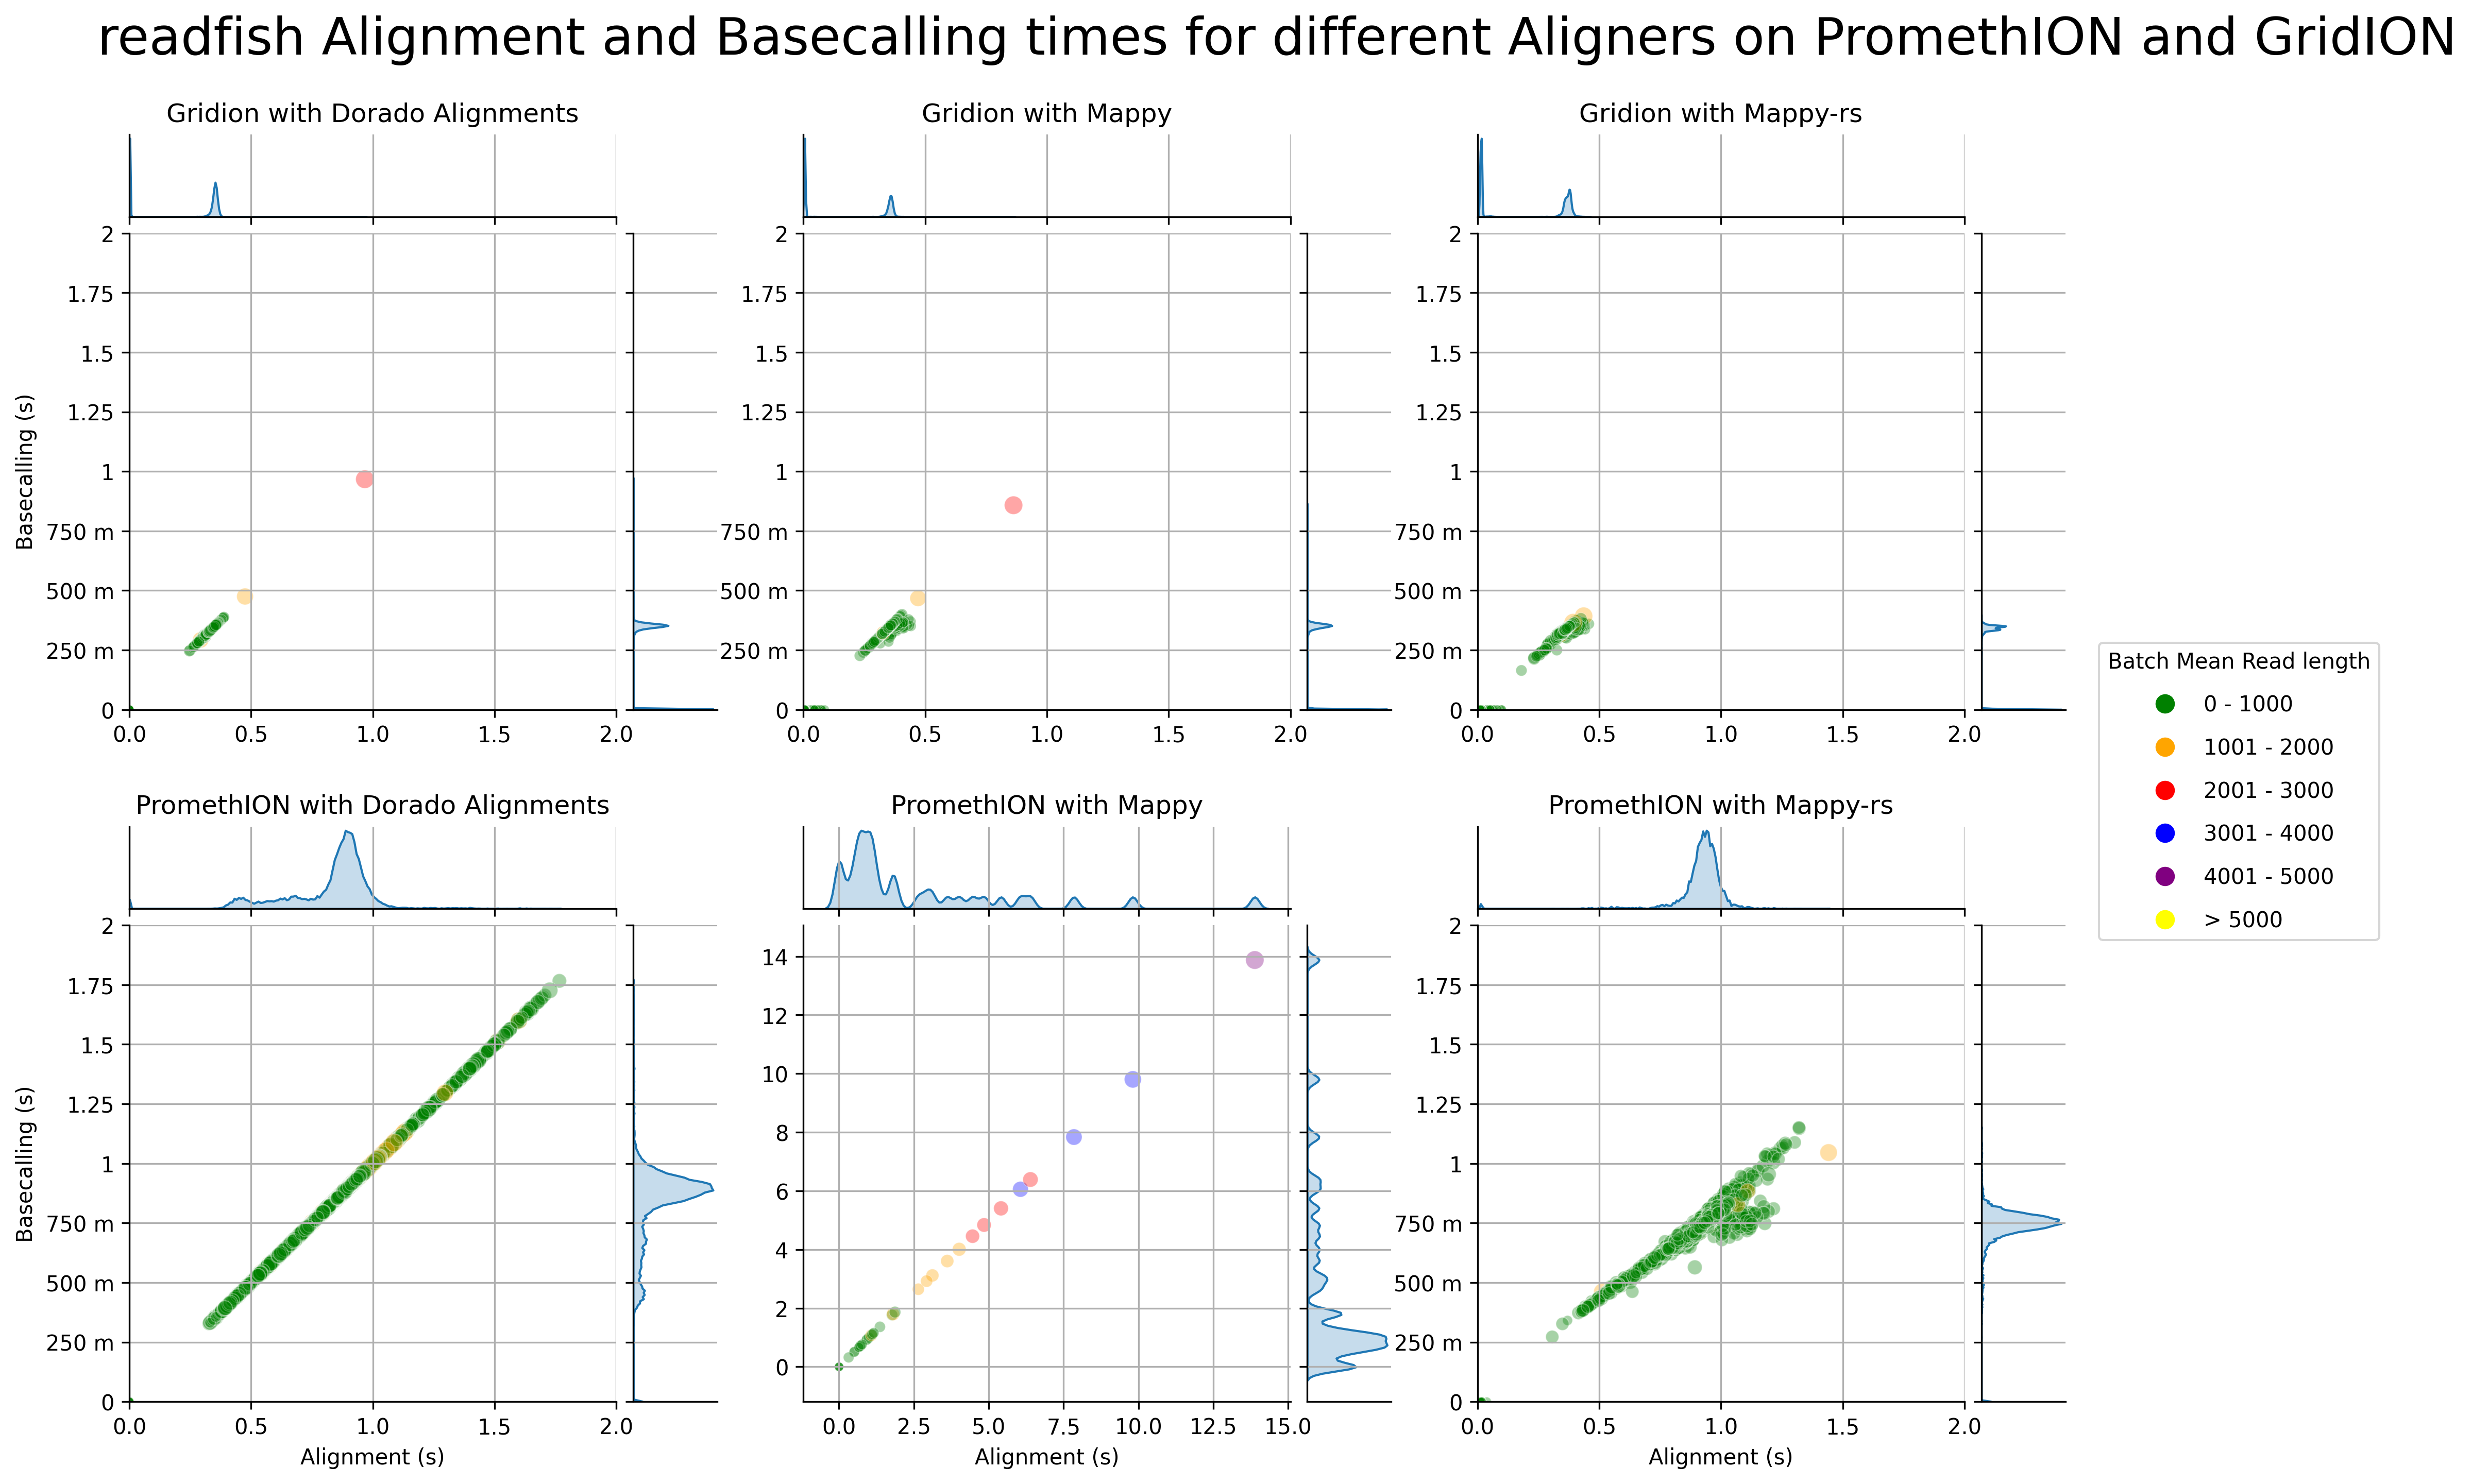

In [150]:
draw_facetted_joints(
    df_all,
    row="Sequencer",
    col="Aligner",
    s="Mean Read Len.",
    ratio=5,
    out_file="test_facetted.pdf",
    legend_limits=[-1, 1000, 2000, 3000, 4000, 5000],
    legend_title="Batch Mean Read length",
)